# AI - MLP Project

## Function output prediction

### Ahmad Salimi - 97106013

In [715]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler

In [716]:
class LossHistory(keras.callbacks.Callback):

    def __init__(self, learner):
        self.learner = learner

    def on_train_begin(self, logs={}):
        self.data = {'loss': [], 'lr': []}
    
    def on_epoch_end(self, batch, logs={}):
       self.data['loss'].append(logs.get('loss'))
       self.data['lr'].append(self.learner.lr)

In [738]:
class FunctionLearner:
    
    def __init__(self, function, data_size, train_domain, noise_sigma=None):
        self.function = function
        self.X, self.y = self.make_random_dataset(data_size, train_domain, noise_sigma)
        self.model = self.create_model()
        self.lr = 0.01
        self.alpha = 0.9
    
    def make_random_dataset(self, size:int, domain, noise_sigma):
        X = np.arange(domain[0], domain[1], (domain[1] - domain[0]) / size).reshape(size, 1)
        y = self.function(X).reshape(size, 1)

        if noise_sigma:
            y += np.random.normal(scale=noise_sigma, size=(size, 1))
        
        self.X_scaler = MinMaxScaler()
        self.X_scaler.fit(X)

        self.y_scaler = MinMaxScaler()
        self.y_scaler.fit(y)

        return X, y

    def step_decay(self, epoch):
        if epoch % 500 == 0:
            self.lr *= 0.9
        return self.lr
    
    def create_model(self):
        model = Sequential()
        model.add(Dense(20, input_dim=1, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(20, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1))

        opt = keras.optimizers.adam(learning_rate=0.01)
        model.compile(optimizer=opt, loss='mse')
        return model
    
    def plot_result(self, x, title=None, xlim=None, ylim=None):
        x.sort()
        plt.figure(figsize=(15, 10))

        if title:
            plt.title(title)
    
        plt.plot(x, self.function(x), color='skyblue', label='original', linewidth=12, zorder=1)
        plt.scatter(self.X, self.y, color='green', label='train data', s=50, zorder=2)
        plt.plot(x, self.predict(x), color='red', label='predicted', linewidth=3, zorder=3)
        plt.grid()
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
        plt.legend()

    def plot_history(self, name, ylim=None):
        plt.figure(figsize=(15, 10))
        plt.plot(np.arange(len(self.loss_history.data[name])), self.loss_history.data[name], color='skyblue', label='name', linewidth=3, zorder=1)
        plt.grid()
        if ylim:
            plt.ylim(ylim)
        plt.legend()
    
    def learn(self, epochs):
        learning_rate = LearningRateScheduler(self.step_decay)
        self.loss_history = LossHistory(self)

        self.model.fit(
            self.X_scaler.transform(self.X), 
            self.y_scaler.transform(self.y), 
            batch_size=10, epochs=epochs, 
            callbacks=[self.loss_history, learning_rate], 
            verbose=0, validation_split=0.1)

        return f'loss = {self.loss_history.data["loss"][-1]:.4e}'
    
    def predict(self, X):
        return self.y_scaler.inverse_transform(
            self.model.predict(
                self.X_scaler.transform(X.reshape(len(X), 1))))

In [739]:
learner = FunctionLearner(lambda x: np.sin(x), 100, (-10, 10))

In [740]:
learner.learn(2000)

'loss = 9.0343e-04'

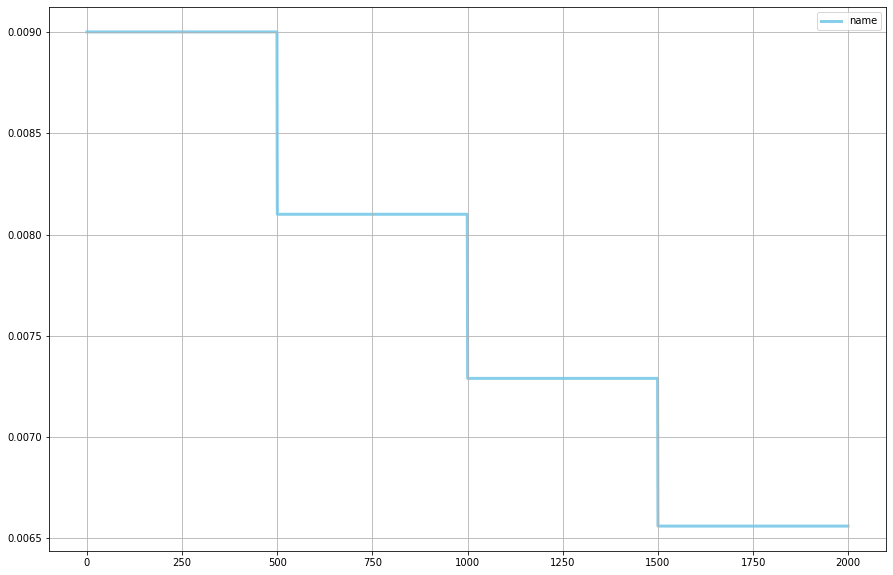

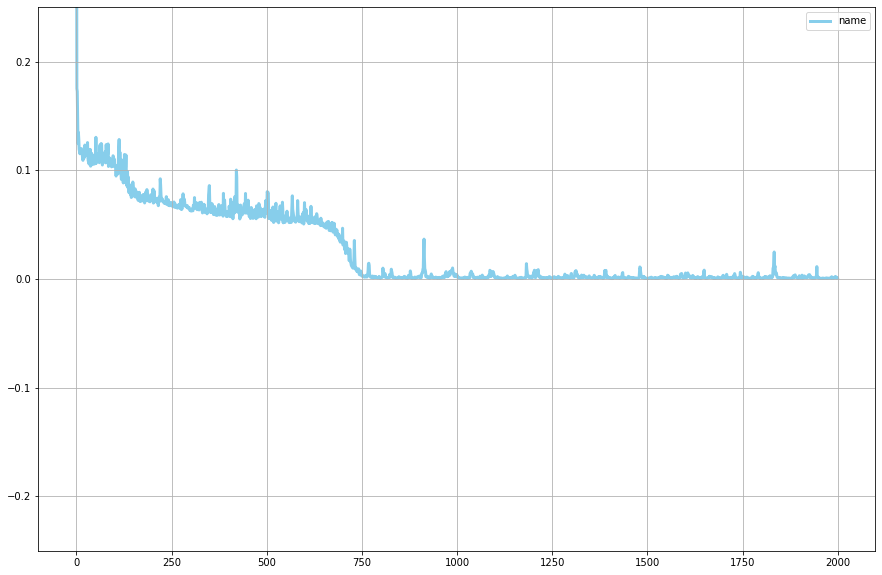

In [741]:
learner.plot_history('lr')
learner.plot_history('loss', ylim=(-.25, .25))

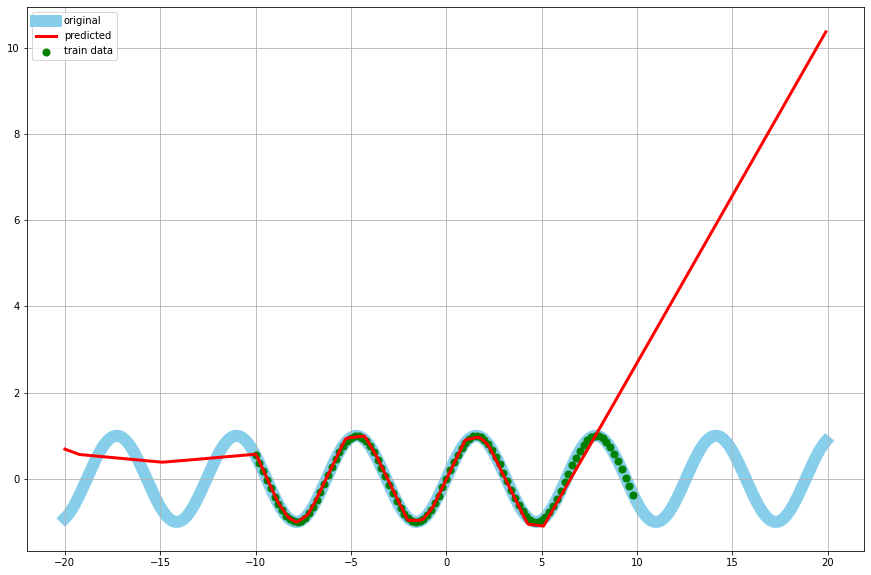

In [742]:
learner.plot_result(np.arange(-20, 20, 0.1))

In [723]:
learner = FunctionLearner(lambda x: 50 * x ** 3 + 2500, 100, (-10, 10))

In [724]:
learner.learn(2000)

'loss = 1.7273e-05'

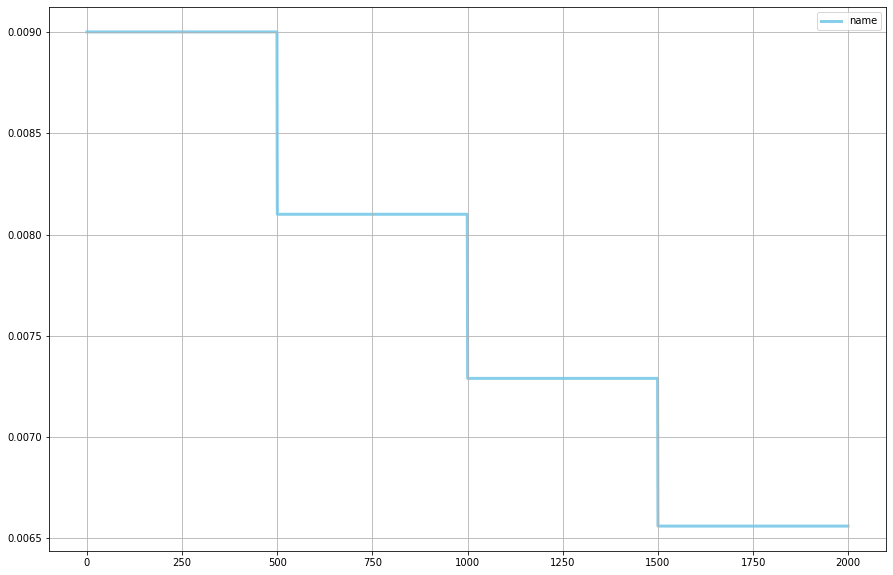

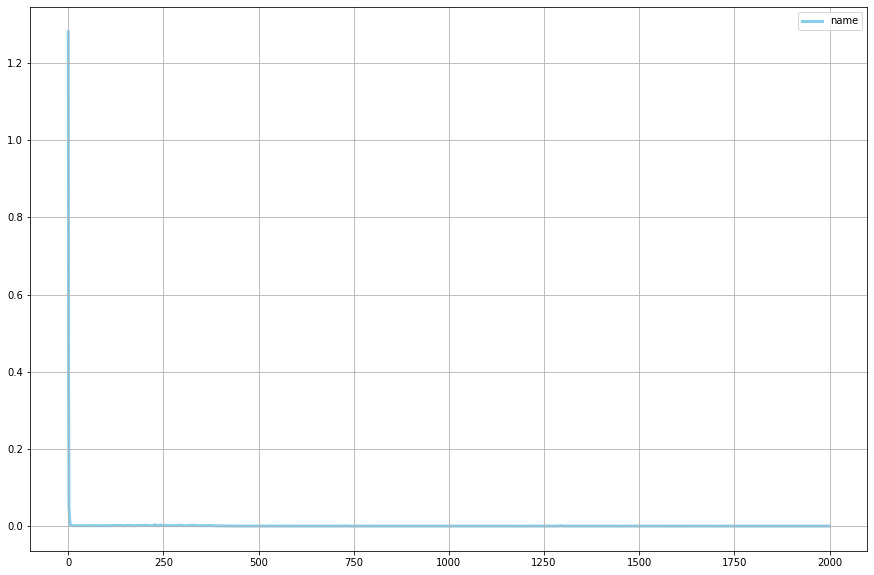

In [725]:
learner.plot_history('lr')
learner.plot_history('loss')

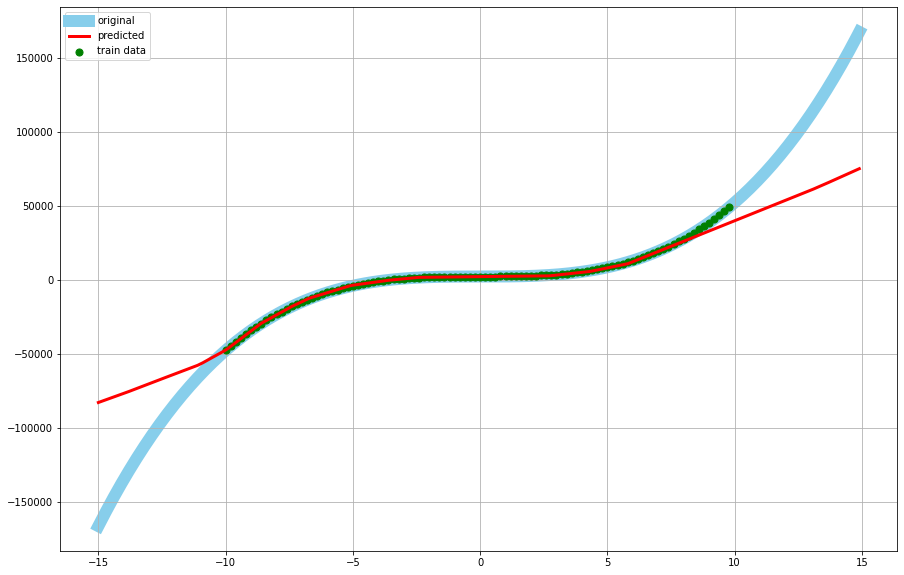

In [726]:
learner.plot_result(np.arange(-15, 15, .1))

start training on noise 0.05
loss = 1.4262e-03
start training on noise 0.1
loss = 2.3417e-03
start training on noise 0.15000000000000002
loss = 3.5717e-03
start training on noise 0.2
loss = 4.3642e-03
start training on noise 0.25
loss = 8.0663e-03
start training on noise 0.3
loss = 1.0677e-02
start training on noise 0.35000000000000003
loss = 1.3540e-02
start training on noise 0.4
loss = 1.3378e-02
start training on noise 0.45
loss = 1.4418e-02


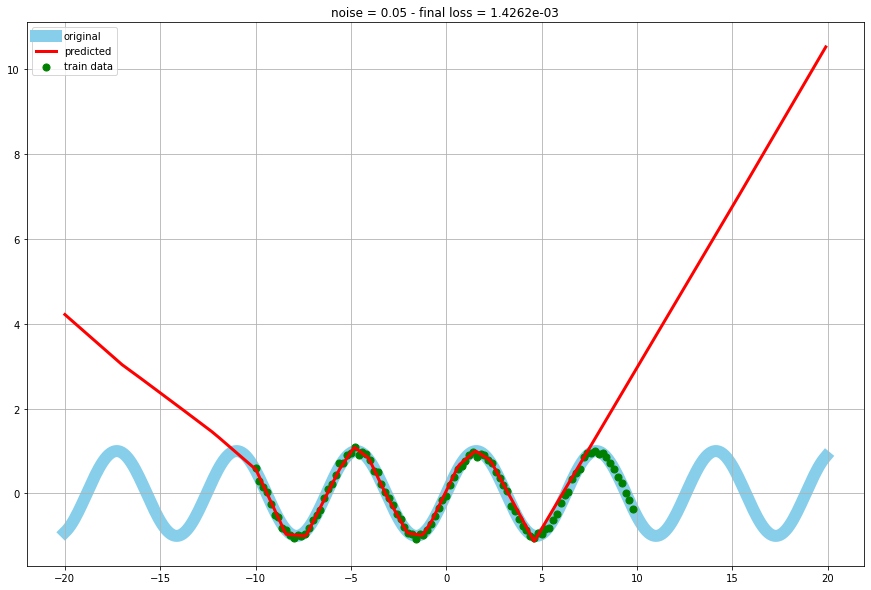

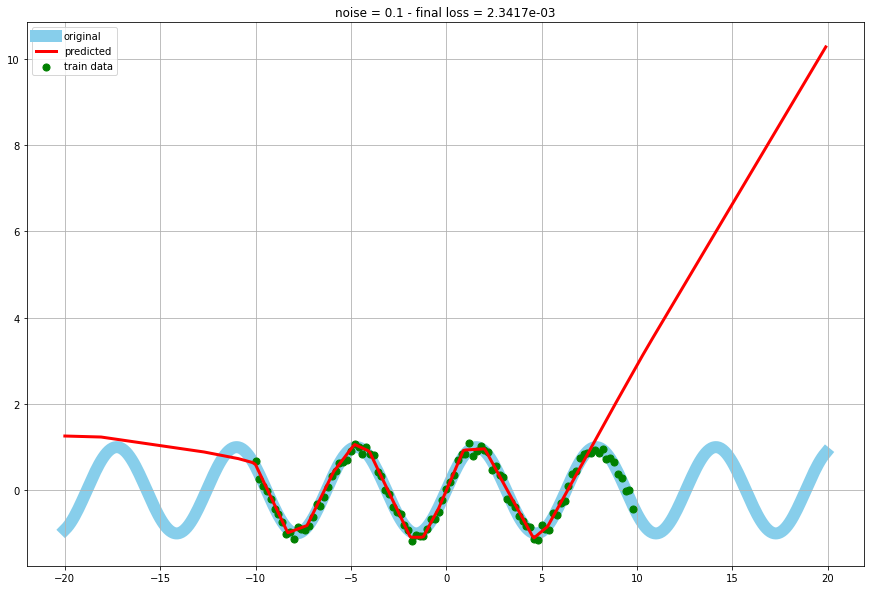

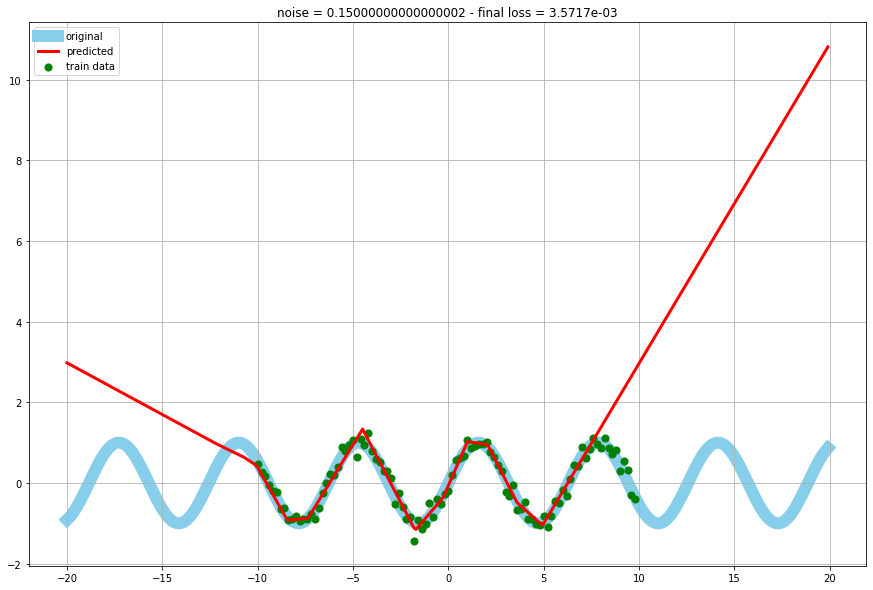

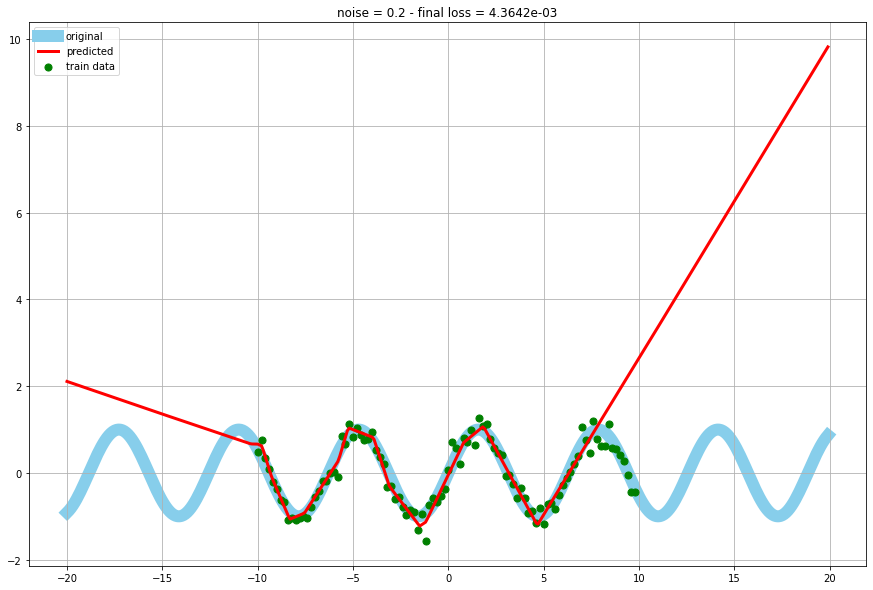

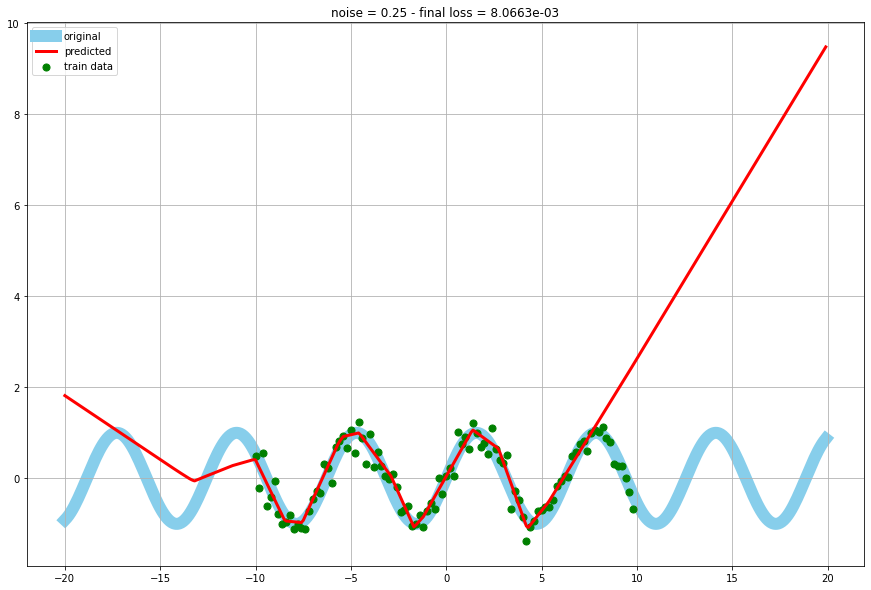

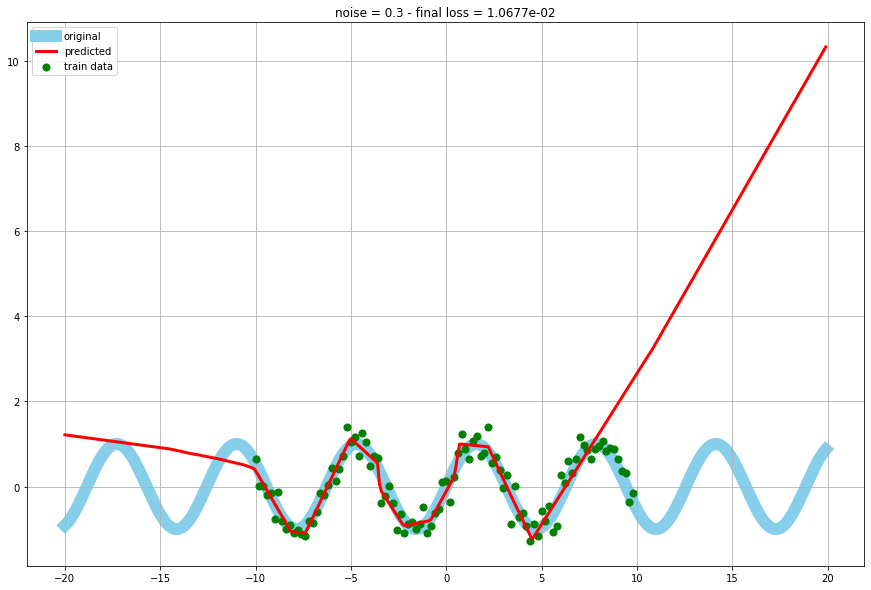

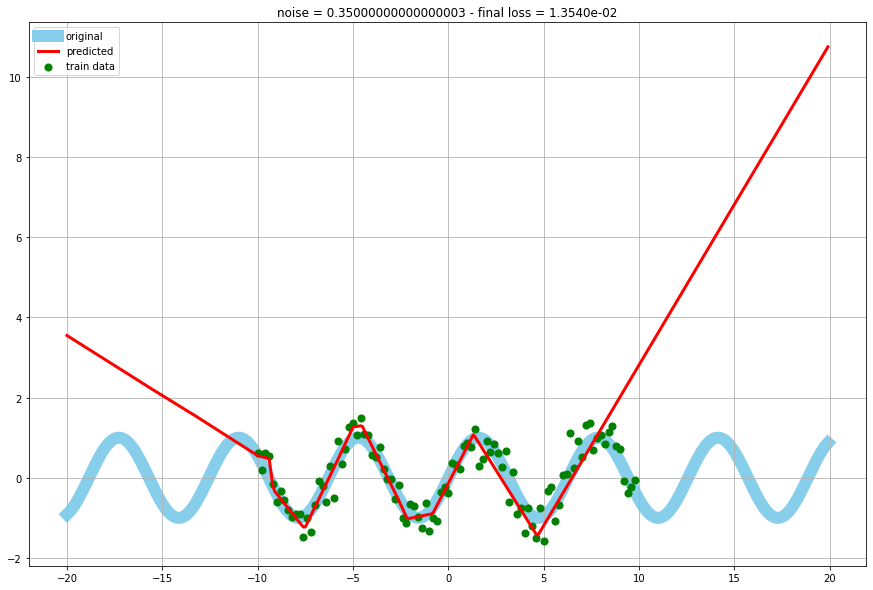

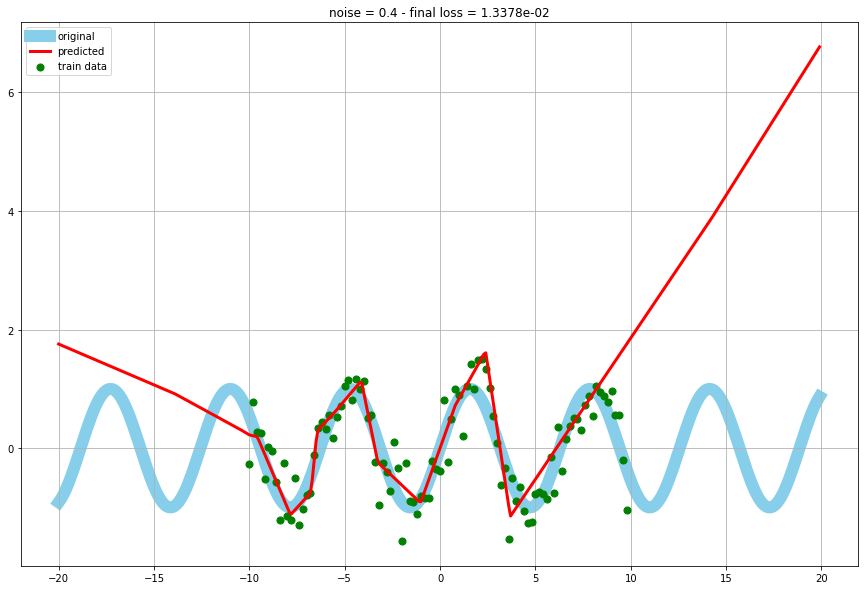

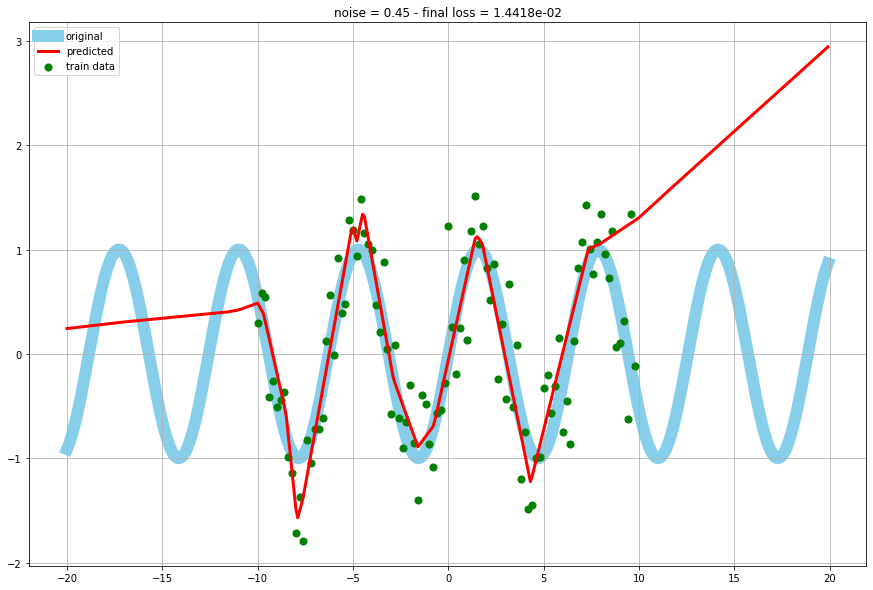

In [727]:
for noise in np.arange(0.05, 0.5, 0.05):
    print(f'start training on noise {noise}')
    learner = FunctionLearner(lambda x: np.sin(x), 100, (-10, 10), noise_sigma=noise)
    loss = learner.learn(4000)
    print(loss)
    learner.plot_result(np.arange(-20, 20, 0.1), f'noise = {noise} - final {loss}')